# Classification of synthetic time series data
Following on from simulating data using SSA, we aim to classify the time series generated with an ML algorithm e.g, Support Vector Machine (SVM), and they need to be similar enough to be difficult to classify.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from tqdm import tqdm

# Import all the functions from the 'src' directory
from stats.report import *
from visualisation.plots import *
from stats.autocorrelation import *
from utils.cv import calculate_cv
from utils.steady_state import save_steady_state
from simulation.simulate_telegraph_model import simulate_two_telegraph_model_systems

%load_ext autoreload
%autoreload 2

## Change the variance ratio over a range, then plot Variance Ratio VS. Prediction Accuracy (SVM, Random Forest, Logistic Regression and Random Classifier)

<span style="color: red">**This will run for a while, so I ran this in a separate python script instead. The script and the data is stored in **var_v_accuracy_plot.py**</span>

<span style='color:red'>**DON'T RUN THIS IN THE NOTEBOOK.**</span>

In [ ]:
# Define system parameters
variance_target_normal = 1200.0
variance_ratios = np.arange(0.1, 3.0, 0.01)

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition
d_stress = d_normal = 1 # Define degradation rates

'''
# Iterate over different variance ratios
for ratio in tqdm.tqdm(variance_ratios, desc="Running Variance Ratio Simulations"):
    variance_target_stress = ratio * variance_target_normal  # Adjust stress variance based on ratio

    # Compute transcription rates (rho) for both conditions
    rho_stress = - (sigma_b_stress + sigma_u_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) * (
        np.sqrt(sigma_b_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) -
        np.sqrt(sigma_b_stress * (sigma_b_stress + sigma_u_stress) + d_stress * (sigma_b_stress + 4 * variance_target_stress * sigma_u_stress))
    ) / (2 * np.sqrt(sigma_b_stress) * sigma_u_stress)

    rho_normal = - (sigma_b_normal + sigma_u_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) * (
        np.sqrt(sigma_b_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) -
        np.sqrt(sigma_b_normal * (sigma_b_normal + sigma_u_normal) + d_normal * (sigma_b_normal + 4 * variance_target_normal * sigma_u_normal))
    ) / (2 * np.sqrt(sigma_b_normal) * sigma_u_normal)

    # Update parameter sets
    parameter_sets = [
        {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
        {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
    ]

    # Set simulation parameters
    time_points = np.arange(0, 144.0, 1.0)  
    size = 200  
    # set the number of iterations to run for the simulation
    num_iterations = 10

    for i in range(num_iterations):
        # Run the simulation
        df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

        # Save dataset for ML classification
        output_dir = f"data/mRNA_trajectories_variance_{int(variance_target_stress)}_{int(variance_target_normal)}"
        os.makedirs(output_dir, exist_ok=True)

        output_file = f"{output_dir}/m_traj_{variance_target_stress}_{variance_target_normal}_{i}.csv"
        df_results.to_csv(output_file, index=False)

        # Extract mRNA trajectories
        stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  
        normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  

        # Statistical report
        stats = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

        # classifiers
        X_train, X_test, y_train, y_test = load_and_split_data(output_file)
        svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
        rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
        log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
        random_accuracy = random_classifier(y_test)
        df_acc_results = pd.DataFrame({
            "Parameter Sets": parameter_sets,
            "Stats": stats,
            "Variance Ratio": ratio,
            "SVM Accuracy": svm_accuracy,
            "Random Forest Accuracy": rf_accuracy,
            "Logistic Regression Accuracy": log_reg_accuracy,
            "Random Classifier Accuracy": random_accuracy
        })

        # Save the accuracy results to a csv file
        if not os.path.isfile("data/accuracy_results.csv"):
            df_acc_results.to_csv("data/accuracy_results.csv", index=False)
        else:
            df_acc_results.to_csv("data/accuracy_results.csv", mode='a', header=False, index=False)
'''

The result

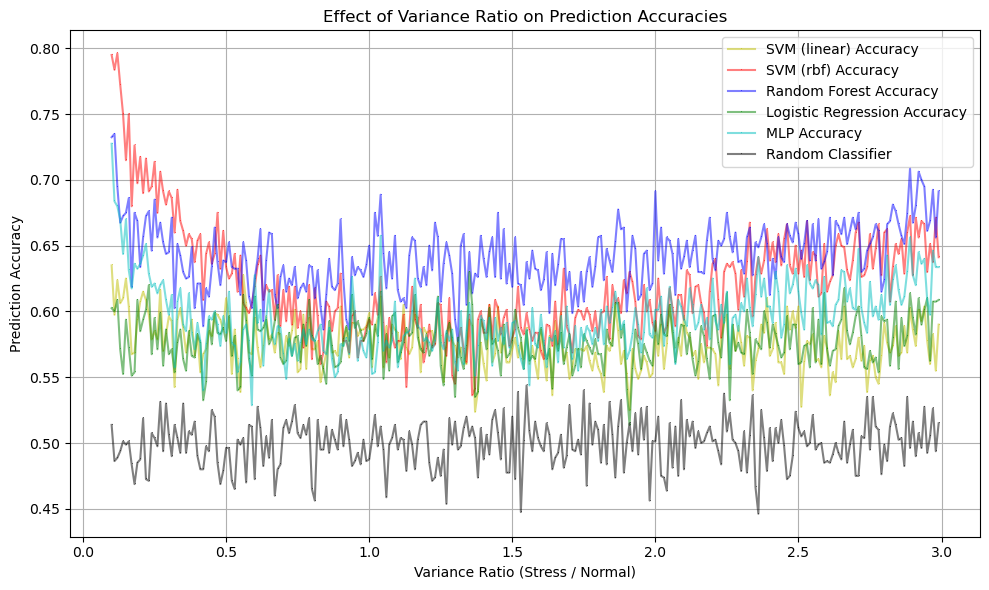

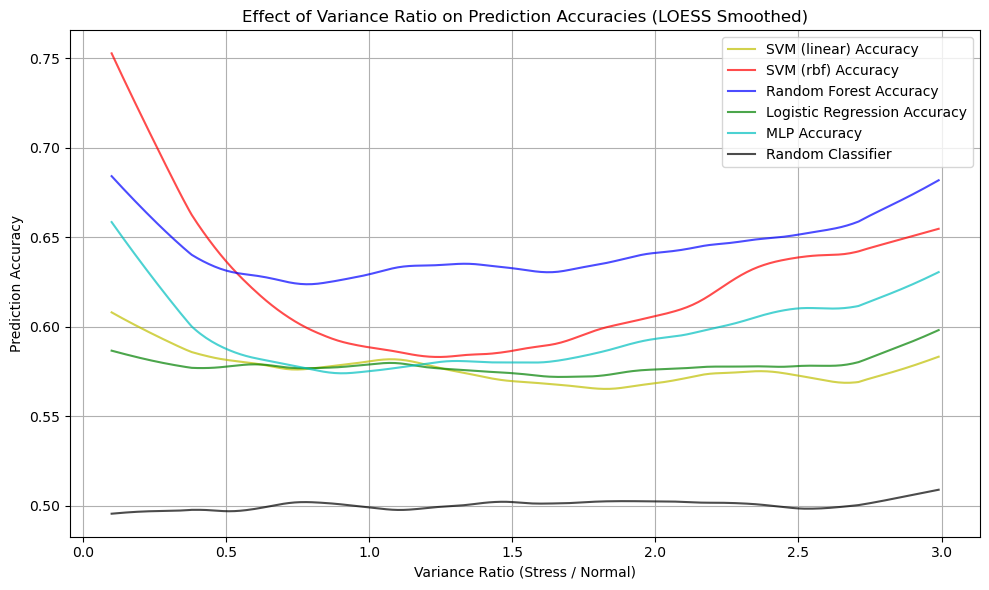

In [2]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_05_03_2025.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()


plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

Benchmarking: keeping the mean constant whilst changing the variance

In [ ]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_26_03_2025.csv")
df_acc_results.head()

Parameter Sets  \
0  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
1  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
2  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
3  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
4  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   

                                               Stats  Variance Ratio  \
0  ({'Stressed Mean': 9.795746268656716, 'Stresse...             0.1   
1  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   
2  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   
3  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   
4  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   

   SVM (rbf) Accuracy  SVM (linear) Accuracy  Random Forest Accuracy  \
0                 1.0                  0.650                     1.0   
1                 1.0                  0.725                     1.0   
2                 1.0                  0.725                     1.0   
3                 1.0                  0.725                     1.0   
4                 1.0                  0.725                     1.0   

   Logistic Regression Accuracy  MLP Accuracy  Random Classifier Accuracy  
0                        0.6625        0.9500                        0.45  
1                        0.7000        0.9375                        0.45  
2                        0.7000        0.9375                        0.45  
3                        0.7000        0.9375                        0.45  
4                        0.7000        0.9375                        0.45

In [4]:
df_lstm_acc_results = pd.read_csv('data/accuracy_results_04_04_2025.csv')
df_lstm_acc_results.head()

Parameter Sets  \
0  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
1  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
2  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
3  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   
4  [{'sigma_u': 18.0, 'sigma_b': 0.82538795220971...   

                                               Stats  Variance Ratio  \
0  ({'Stressed Mean': 9.795746268656716, 'Stresse...             0.1   
1  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   
2  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   
3  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   
4  ({'Stressed Mean': 10.174776119402985, 'Stress...             0.1   

   LSTM Accuracy  
0         0.5250  
1         0.9875  
2         0.9875  
3         0.9875  
4         0.9875

In [5]:
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_lstm_acc_results.groupby("Variance Ratio")["LSTM Accuracy"].mean()

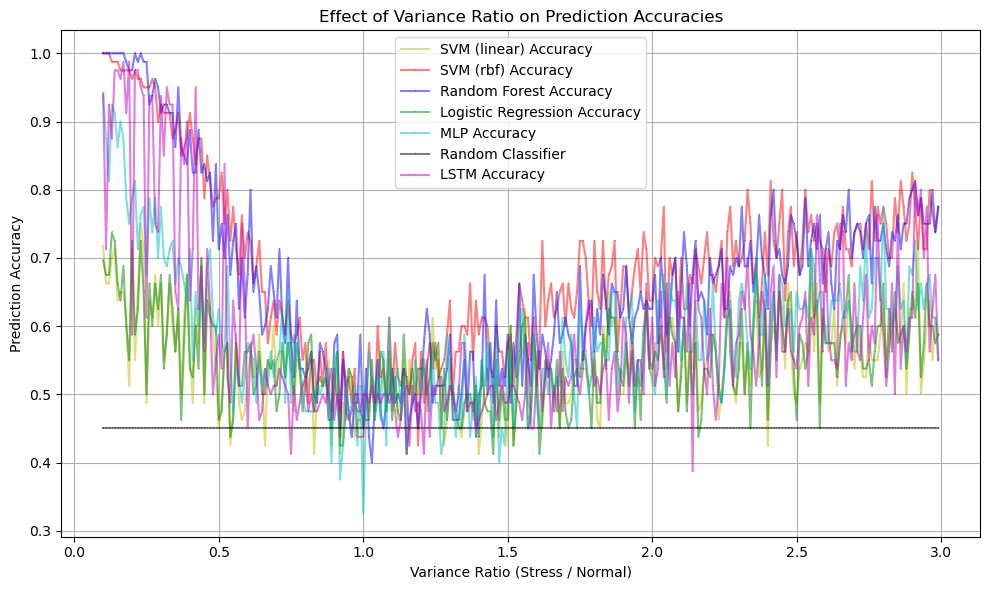

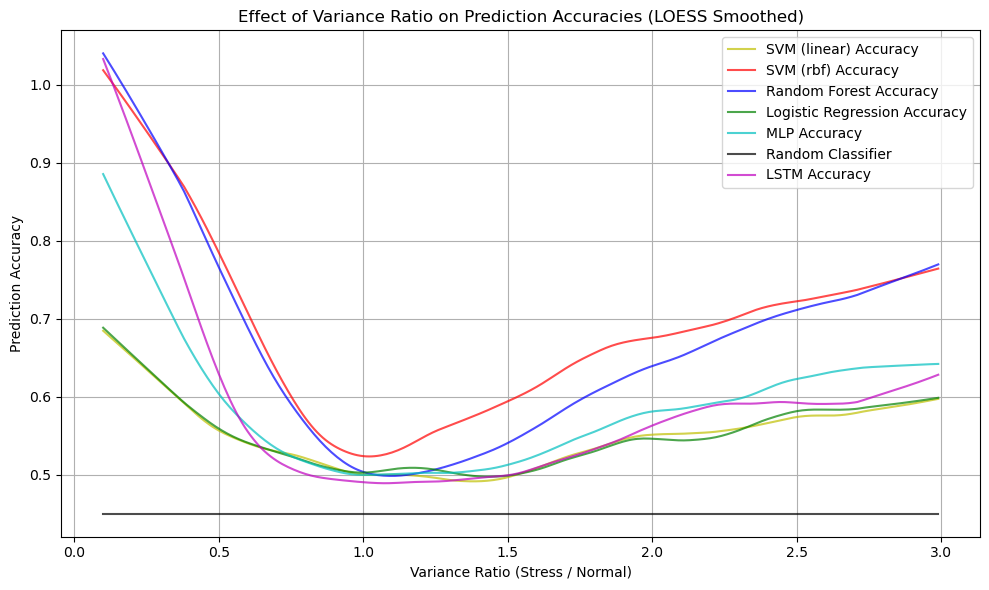

In [ ]:
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color='m', label="LSTM Accuracy", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="LSTM Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Benchmarking: keeping the mean and autocorr constant whilst changing variance

In [2]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_03_04_2025.csv")
df_acc_results.head()

Parameter Sets  \
0  [{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...   
1  [{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...   
2  [{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...   
3  [{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...   
4  [{'sigma_u': 18.0, 'sigma_b': 0.61731419342937...   

                                               Stats  Variance Ratio  \
0  ({'Stressed Mean': 10.141908396946565, 'Stress...             0.1   
1  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   
2  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   
3  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   
4  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   

   SVM (rbf) Accuracy  SVM (linear) Accuracy  Random Forest Accuracy  \
0              1.0000                 0.6625                     1.0   
1              0.9875                 0.7750                     1.0   
2              0.9875                 0.7750                     1.0   
3              0.9875                 0.7750                     1.0   
4              0.9875                 0.7750                     1.0   

   Logistic Regression Accuracy  MLP Accuracy  Random Classifier Accuracy  
0                         0.675        0.9375                        0.45  
1                         0.775        0.8875                        0.45  
2                         0.775        0.8875                        0.45  
3                         0.775        0.8875                        0.45  
4                         0.775        0.8875                        0.45

In [3]:
df_lstm_acc_results = pd.read_csv("data/accuracy_results_06_04_2025.csv")
df_lstm_acc_results.head()

Parameter Sets  \
0  [{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...   
1  [{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...   
2  [{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...   
3  [{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...   
4  [{'sigma_u': 18.0, 'sigma_b': 0.61731419341922...   

                                               Stats  Variance Ratio  \
0  ({'Stressed Mean': 10.141908396946565, 'Stress...             0.1   
1  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   
2  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   
3  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   
4  ({'Stressed Mean': 9.982366412213741, 'Stresse...             0.1   

   LSTM Accuracy  
0         0.9750  
1         0.9875  
2         0.9875  
3         0.9875  
4         0.9875

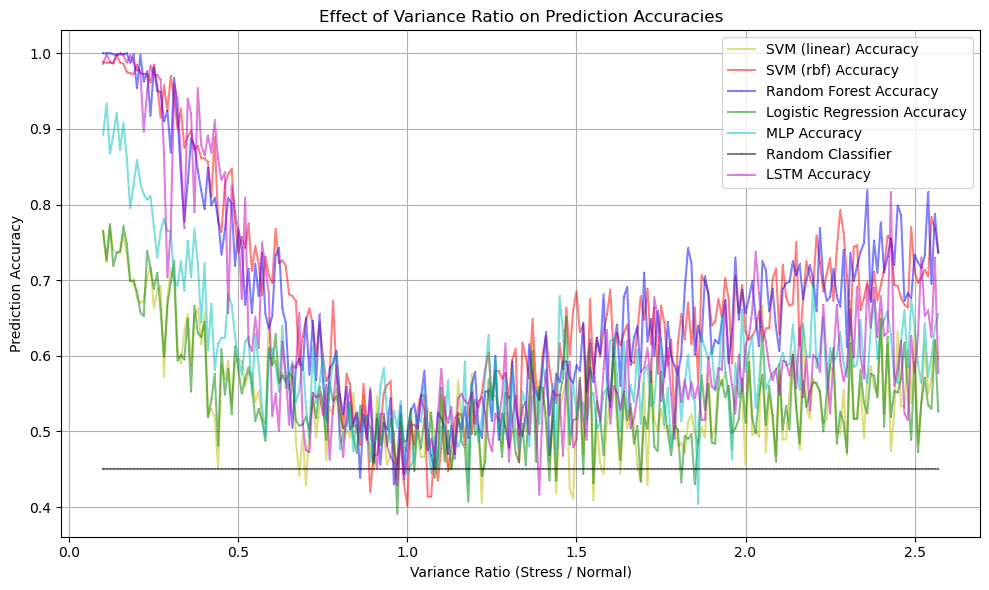

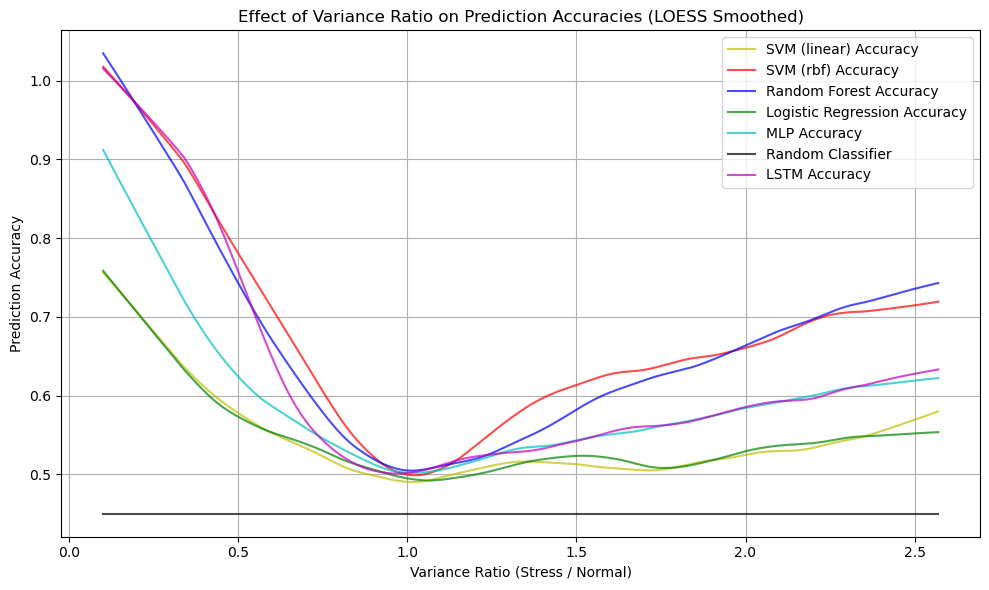

In [ ]:
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_lstm_acc_results.groupby("Variance Ratio")["LSTM Accuracy"].mean()

plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs Classifier Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color='m', label="LSTM Accuracy", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="LSTM Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Finetuned LSTM Model Benchmark
!! An accidental mistake was made for the LSTM classifier, where ``use_conv1d`` and ``use_attention`` were set to ``True``, AND, ``num_attention_heads`` was set to `4` but this somehow made it a better classifer than the LSTM Conv1D classifier, the parameters used for LSTM classifier:

```
def lstm_classifier(X_train, X_val, X_test, y_train, y_val, y_test, 
                    input_size=None, hidden_size=64, num_layers=2, 
                    output_size=None, dropout_rate=0.3, learning_rate=0.001, 
                    batch_size=64, epochs=50, patience=10, bidirectional=True, use_attention=True, use_conv1d=True): 
```

Parameters used for the LSTM Conv1D classifier:

```
def lstm_conv1d_classifier(X_train, X_val, X_test, y_train, y_val, y_test, 
                    input_size=None, hidden_size=64, num_layers=2, 
                    output_size=None, dropout_rate=0.01, learning_rate=0.001, 
                    batch_size=32, epochs=50, patience=10, bidirectional=True, use_attention=False, use_conv1d=True):
```


In [ ]:
################## Rectify the LSTM Accuracy column name ##################
# df_acc_results = pd.read_csv("data/accuracy_results_12_04_2025.csv")
# df_acc_results = pd.read_csv("data/accuracy_results_11_04_2025.csv")
# change the LSTM Accuracy column to LSTM Conv1D Attnention Accuracy
# df_acc_results.rename(columns={'LSTM Accuracy': 'LSTM Conv1D 4-Head Attention Accuracy'}, inplace=True)
# save the dataframe to a csv file
# df_acc_results.to_csv("data/accuracy_results_11_04_2025.csv", index=False)

################# Rectify the LSTM Accuracy column name ##################

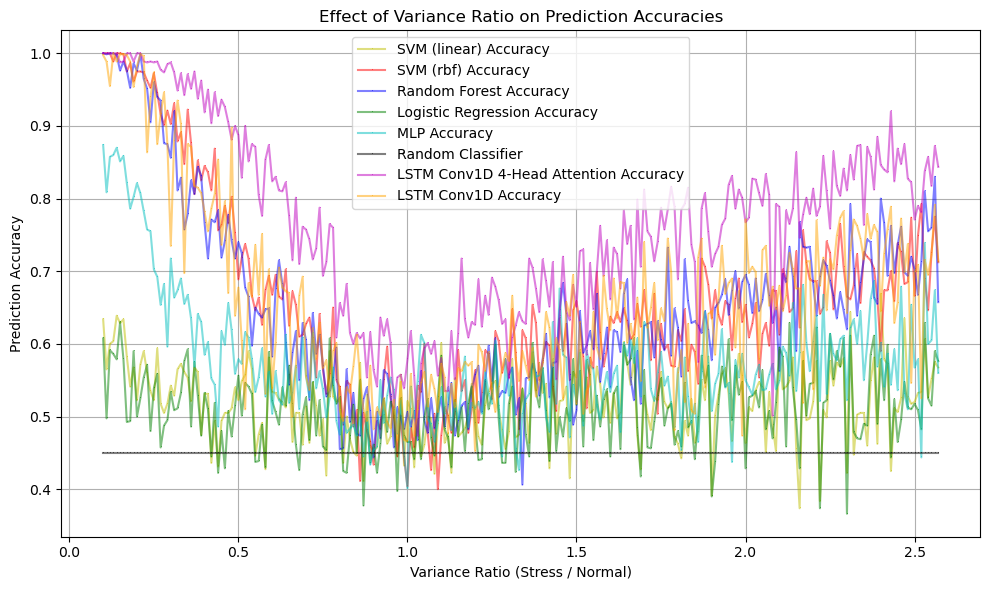

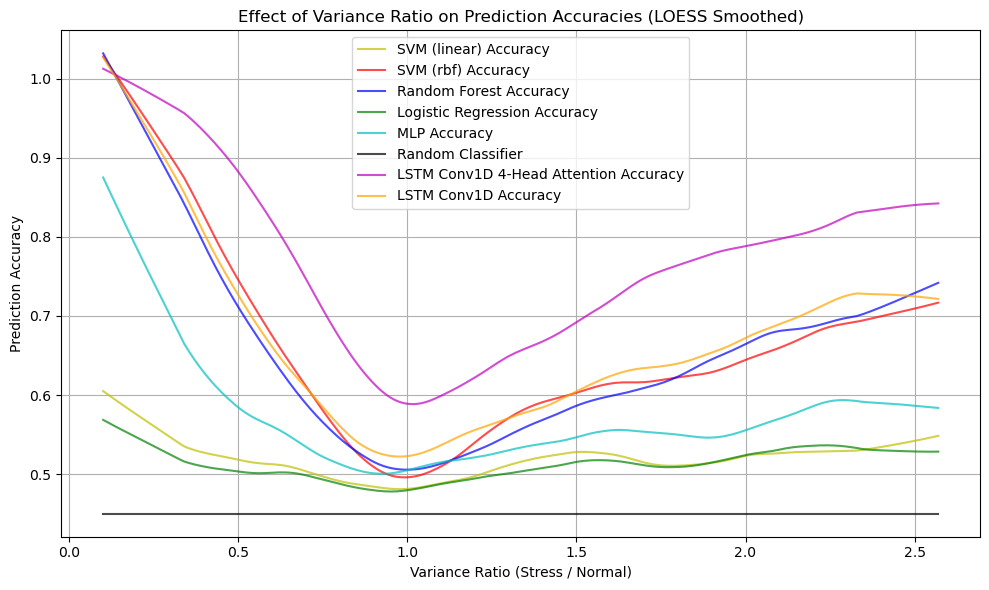

In [7]:
# Read in accuracy data
# df_acc_results = pd.read_csv("data/accuracy_results_12_04_2025.csv")
df_acc_results = pd.read_csv("data/accuracy_results_11_04_2025.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy_conv1d_4_attention_accuracy = df_acc_results.groupby("Variance Ratio")["LSTM Conv1D 4-Head Attention Accuracy"].mean()
lstm_conv1d_accuracy = df_acc_results.groupby("Variance Ratio")["LSTM Conv1D Accuracy"].mean()
##### plotting
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy_conv1d_4_attention_accuracy, marker=',', linestyle='-', color='m', label="LSTM Conv1D 4-Head Attention Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_conv1d_accuracy, marker=',', linestyle='-', color='orange', label="LSTM Conv1D Accuracy", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_conv1d_4_attention_loess = lowess(lstm_accuracy_conv1d_4_attention_accuracy, variance_ratios_recorded, frac=0.2)
lstm_conv1d_loess = lowess(lstm_conv1d_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_conv1d_4_attention_loess[:, 0], lstm_conv1d_4_attention_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="LSTM Conv1D 4-Head Attention Accuracy")
plt.plot(lstm_conv1d_loess[:, 0], lstm_conv1d_loess[:, 1], linestyle='-', color='orange', alpha=0.7, label="LSTM Conv1D Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Benchmark (Pre-Trained) IY002A LSTM Model Against Others

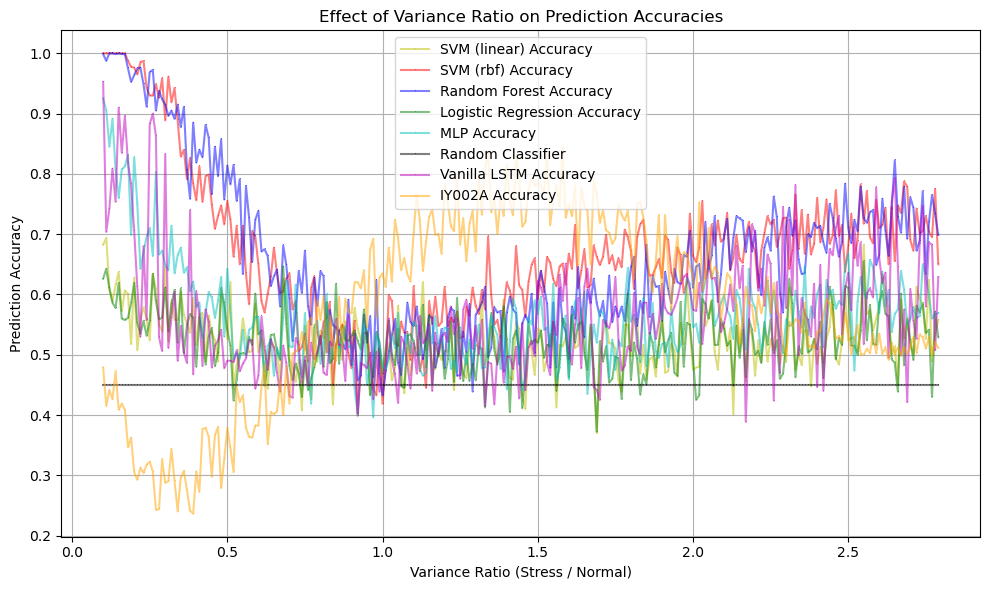

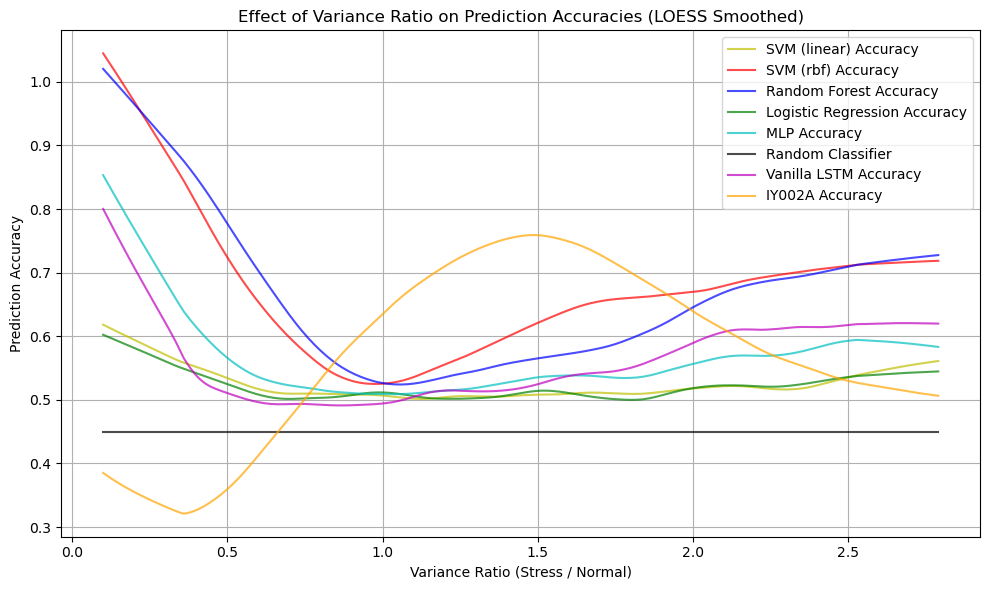

In [ ]:
# Read in accuracy data
df_acc_results = pd.read_csv("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY002/data/IY002A.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_acc_results.groupby("Variance Ratio")["Vanilla LSTM Accuracy"].mean()
iy002a_accuracy = df_acc_results.groupby("Variance Ratio")["IY002A Accuracy"].mean()
##### plotting
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs Classifier Accuracies
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color='m', label="Vanilla LSTM Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, iy002a_accuracy, marker=',', linestyle='-', color='orange', label="IY002A Accuracy", alpha=0.5)

plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)
iy002a_loess = lowess(iy002a_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="Vanilla LSTM Accuracy")
plt.plot(iy002a_loess[:, 0], iy002a_loess[:, 1], linestyle='-', color='orange', alpha=0.7, label="IY002A Accuracy")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savigs/variance_ratio_vs_accuracy_loess.png")
plt.show()

## Benchmark IY001A LSTM Model

In [1]:
# Define path to the data directory containing IY007 output
data_dir = '/home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/'

def load_cv_data():
    """Load CV data from IY007 simulation results"""
    cv_data = []
    
    # Find all CV trajectory directories (they follow pattern mRNA_trajectories_cv_X.XX_Y.YY)
    pattern = os.path.join(data_dir, 'mRNA_trajectories_cv_*_*')
    cv_dirs = glob.glob(pattern)
    
    if not cv_dirs:
        print(f"No CV trajectory directories found in {data_dir}")
        return None
    
    print(f"Found {len(cv_dirs)} CV trajectory directories")
    
    for cv_dir in tqdm(cv_dirs, desc="Processing CV directories"):
        # Extract CV values from directory name
        dir_name = os.path.basename(cv_dir)
        cv_parts = dir_name.split('_')
        cv_stress = float(cv_parts[-2])  # Second to last part is stress CV
        cv_normal = float(cv_parts[-1])  # Last part is normal CV
        cv_ratio = cv_stress / cv_normal
        
        # Find the steady state directory
        steady_state_dir = os.path.join(cv_dir, 'steady_state_trajectories')
        if not os.path.exists(steady_state_dir):
            print(f"Steady state directory not found in {cv_dir}")
            continue
        
        # Process each file in the steady state directory
        ss_files = glob.glob(os.path.join(steady_state_dir, '*_SS.csv'))
        
        if not ss_files:
            print(f"No steady state files found in {steady_state_dir}")
            continue
        
        # Process each steady state file
        for ss_file in ss_files:
            try:
                # Load the steady state data
                df = pd.read_csv(ss_file)
                
                # Split data by condition
                stress_data = df[df['label'] == 0].iloc[:, 1:].values
                normal_data = df[df['label'] == 1].iloc[:, 1:].values
                
                # Calculate observed statistics for each condition
                stress_mean = np.mean(stress_data)
                stress_variance = np.var(stress_data)
                normal_mean = np.mean(normal_data)
                normal_variance = np.var(normal_data)
                
                # Calculate observed CVs
                observed_cv_stress = calculate_cv(stress_variance, stress_mean)
                observed_cv_normal = calculate_cv(normal_variance, normal_mean)
                observed_cv_ratio = observed_cv_stress / observed_cv_normal
                
                # Store results
                cv_data.append({
                    'specified_cv_stress': cv_stress,
                    'specified_cv_normal': cv_normal,
                    'specified_cv_ratio': cv_ratio,
                    'observed_cv_stress': observed_cv_stress,
                    'observed_cv_normal': observed_cv_normal,
                    'observed_cv_ratio': observed_cv_ratio,
                    'stress_mean': stress_mean,
                    'stress_variance': stress_variance,
                    'normal_mean': normal_mean,
                    'normal_variance': normal_variance
                })
                
            except Exception as e:
                print(f"Error processing {ss_file}: {e}")
    
    # Convert to DataFrame
    return pd.DataFrame(cv_data)

## Benchmarking: Transformer

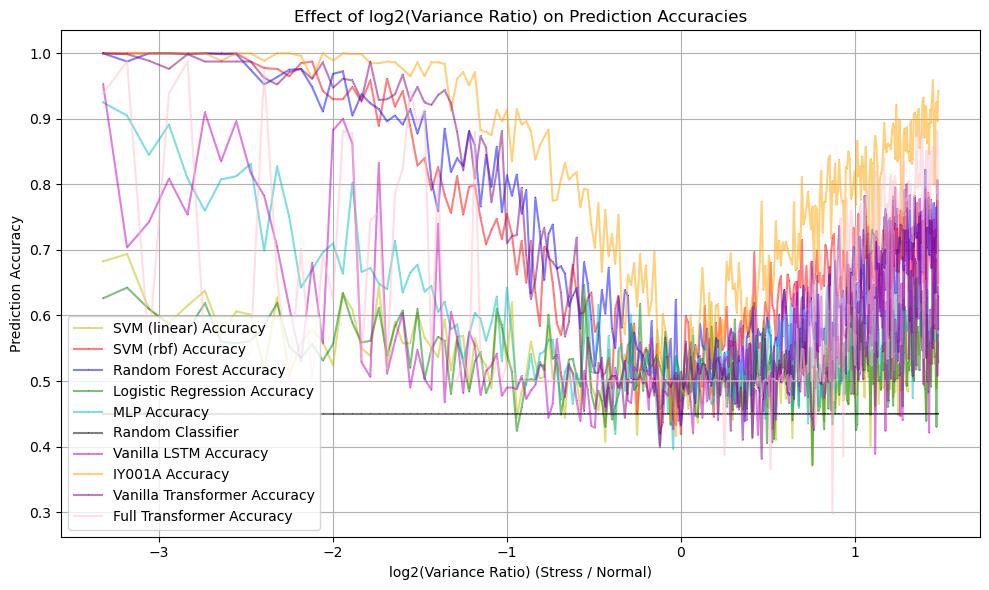

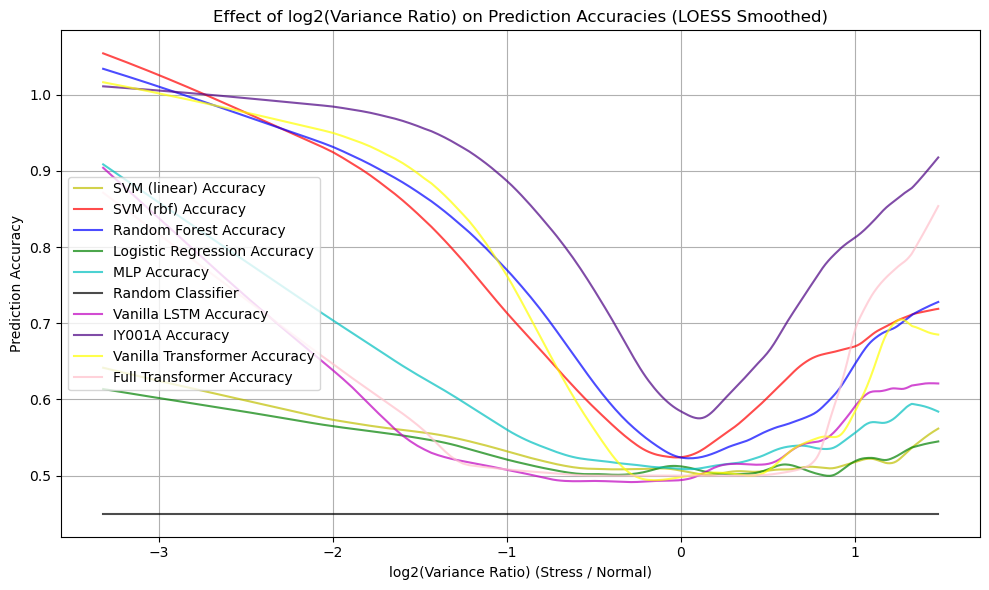

In [2]:
import numpy as np

# Read in accuracy data
df_acc_results = pd.read_csv("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY004/data/IY004B.csv")
# Compute log2 of variance ratios
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
log2_variance_ratios = np.log2(variance_ratios_recorded)

linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_acc_results.groupby("Variance Ratio")["Vanilla LSTM Accuracy"].mean()
iy001a_accuracy = df_acc_results.groupby("Variance Ratio")["IY001A Accuracy"].mean()
vanilla_transformer_accuracy = df_acc_results.groupby("Variance Ratio")["Vanilla Transformer Accuracy"].mean()
full_transformer_accuracy = df_acc_results.groupby("Variance Ratio")["Full Transformer Accuracy"].mean()

plt.figure(figsize=(10, 6))
plt.plot(log2_variance_ratios, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.plot(log2_variance_ratios, lstm_accuracy, marker=',', linestyle='-', color='m', label="Vanilla LSTM Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, iy001a_accuracy, marker=',', linestyle='-', color='orange', label="IY001A Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, vanilla_transformer_accuracy, marker=',', linestyle='-', color='purple', label="Vanilla Transformer Accuracy", alpha=0.5)
plt.plot(log2_variance_ratios, full_transformer_accuracy, marker=',', linestyle='-', color='pink', label="Full Transformer Accuracy", alpha=0.5)

plt.xlabel("log2(Variance Ratio) (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of log2(Variance Ratio) on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_log2.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, log2_variance_ratios, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, log2_variance_ratios, frac=0.2)
rf_loess = lowess(rf_accuracy, log2_variance_ratios, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, log2_variance_ratios, frac=0.2)
mlp_loess = lowess(mlp_accuracy, log2_variance_ratios, frac=0.2)
random_loess = lowess(random_accuracy, log2_variance_ratios, frac=0.2)
lstm_loess = lowess(lstm_accuracy, log2_variance_ratios, frac=0.2)
iy001a_loess = lowess(iy001a_accuracy, log2_variance_ratios, frac=0.2)
vanilla_transformer_loess = lowess(vanilla_transformer_accuracy, log2_variance_ratios, frac=0.2)
full_transformer_loess = lowess(full_transformer_accuracy, log2_variance_ratios, frac=0.2)

plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color='m', alpha=0.7, label="Vanilla LSTM Accuracy")
plt.plot(iy001a_loess[:, 0], iy001a_loess[:, 1], linestyle='-', color='indigo', alpha=0.7, label="IY001A Accuracy")
plt.plot(vanilla_transformer_loess[:, 0], vanilla_transformer_loess[:, 1], linestyle='-', color='yellow', alpha=0.7, label="Vanilla Transformer Accuracy")
plt.plot(full_transformer_loess[:, 0], full_transformer_loess[:, 1], linestyle='-', color='pink', alpha=0.7, label="Full Transformer Accuracy")

plt.xlabel("log2(Variance Ratio) (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of log2(Variance Ratio) on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess_log2.png")
plt.show()


The variance ratio has to be within a reasonable range:
- Coefficient of Variance = (Std / Mean) should be lower than 5.
- Fano facor (FF) should be less than 20. 

To do this, variance ratio has to be 2.0 or lower to accommodate CV < 5


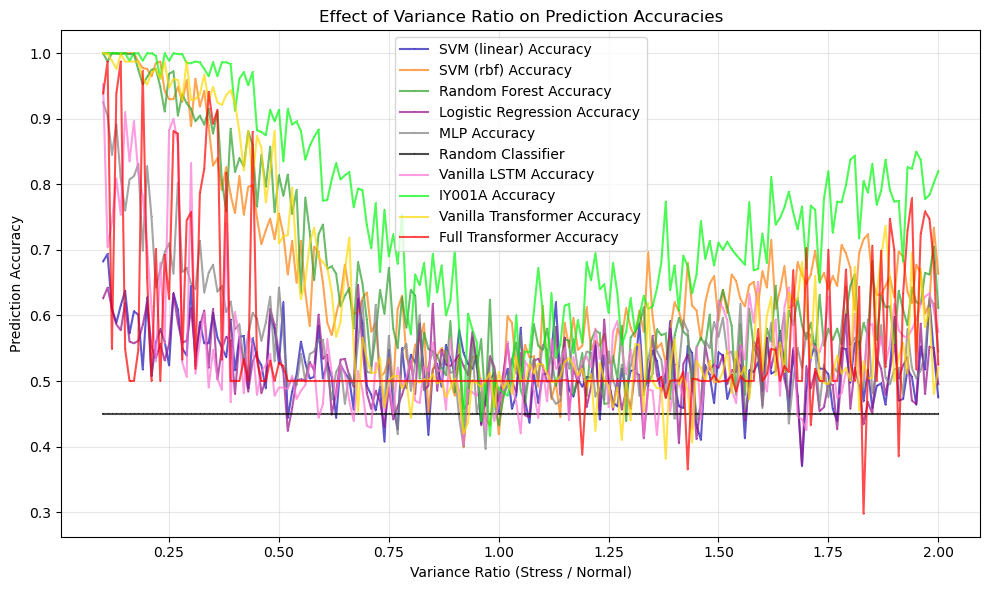

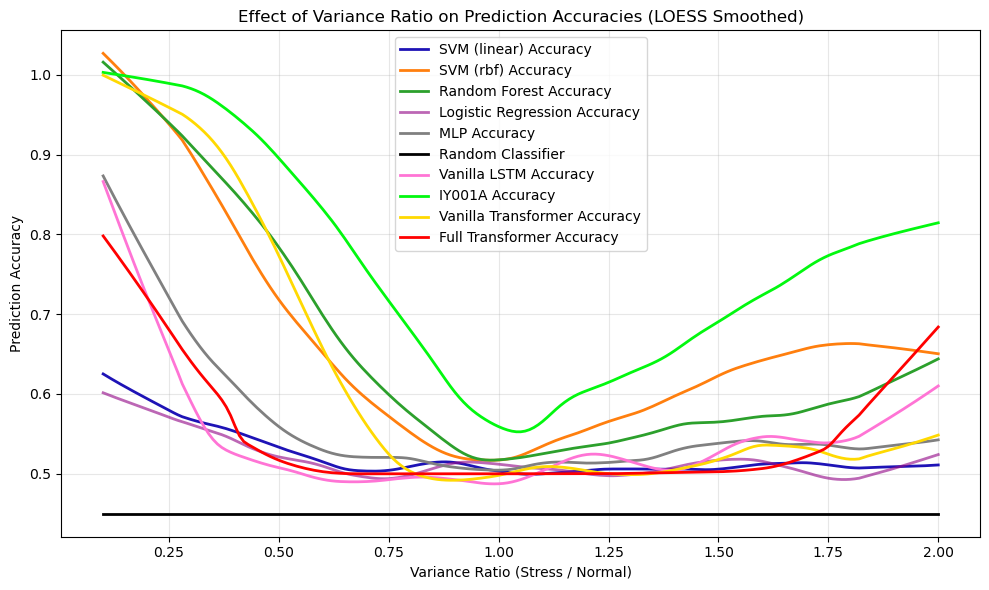

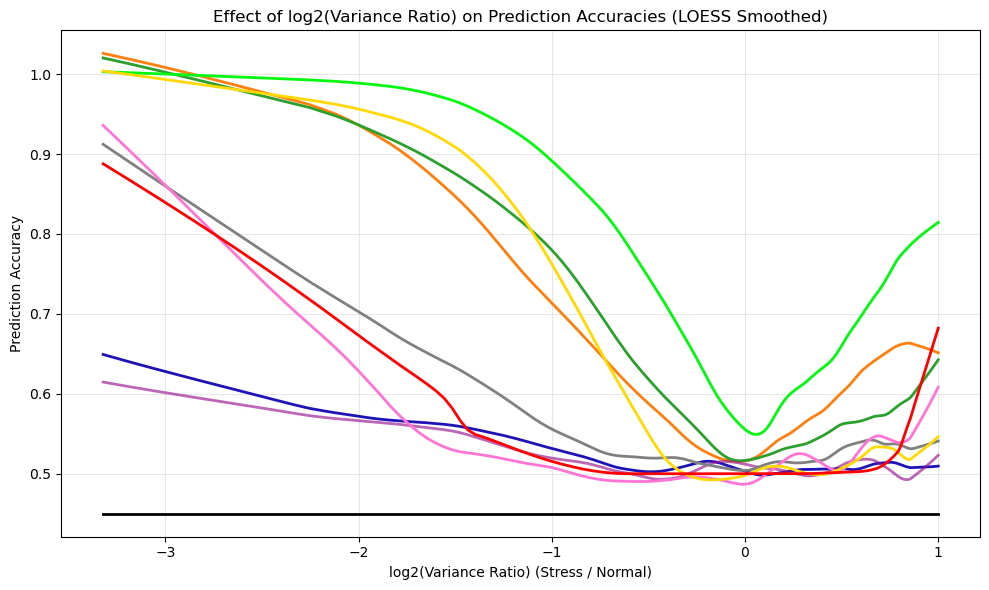

In [9]:

import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
# Read in accuracy data, 
df_acc_results = pd.read_csv("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY004/data/IY004B.csv")

# Filter dataset to only include variance ratio <= 2.0
filtered_df = df_acc_results[df_acc_results["Variance Ratio"] <= 2.0]

variance_ratios_recorded = filtered_df["Variance Ratio"].unique()
#then compute mean and loess
linear_svm_accuracy = filtered_df.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = filtered_df.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = filtered_df.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = filtered_df.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = filtered_df.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = filtered_df.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = filtered_df.groupby("Variance Ratio")["Vanilla LSTM Accuracy"].mean()
iy001a_accuracy = filtered_df.groupby("Variance Ratio")["IY001A Accuracy"].mean()
vanilla_transformer_accuracy = filtered_df.groupby("Variance Ratio")["Vanilla Transformer Accuracy"].mean()
full_transformer_accuracy = filtered_df.groupby("Variance Ratio")["Full Transformer Accuracy"].mean()

# Define a better color palette for improved visibility
colors = {
    'linear_svm': "#1E13B6",      
    'rbf_svm': '#ff7f0e',          # Orange
    'random_forest': '#2ca02c',    # Green
    'logistic_reg': "#96118ba3",    # Pink
    'mlp': 'gray',              #   Gray
    'random': 'Black',           # Black
    'lstm': "#ff74d5",             # Pink
    'iy001a': "#02f80f",           # Yellow-green
    'iy002a': '#17becf',           # Cyan
    'vanilla_transformer': "#ffd901", # Yellow
    'full_transformer': "#ff0000"  # Red
}

# Plot the raw data with improved colors
plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs Classifier Accuracies
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color=colors['linear_svm'], label="SVM (linear) Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color=colors['rbf_svm'], label="SVM (rbf) Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color=colors['random_forest'], label="Random Forest Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color=colors['logistic_reg'], label="Logistic Regression Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color=colors['mlp'], label="MLP Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color=colors['random'], label="Random Classifier", alpha=0.7)
plt.plot(variance_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color=colors['lstm'], label="Vanilla LSTM Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, iy001a_accuracy, marker=',', linestyle='-', color=colors['iy001a'], label="IY001A Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, vanilla_transformer_accuracy, marker=',', linestyle='-', color=colors['vanilla_transformer'], label="Vanilla Transformer Accuracy", alpha=0.7)
plt.plot(variance_ratios_recorded, full_transformer_accuracy, marker=',', linestyle='-', color=colors['full_transformer'], label="Full Transformer Accuracy", alpha=0.7)

plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_better_colors.png", bbox_inches='tight')
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, variance_ratios_recorded, frac=0.2)
iy001a_loess = lowess(iy001a_accuracy, variance_ratios_recorded, frac=0.2)
vanilla_transformer_loess = lowess(vanilla_transformer_accuracy, variance_ratios_recorded, frac=0.2)
full_transformer_loess = lowess(full_transformer_accuracy, variance_ratios_recorded, frac=0.2)
# Plot the LOESS smoothed data with improved colors
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color=colors['linear_svm'], linewidth=2, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color=colors['rbf_svm'], linewidth=2, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color=colors['random_forest'], linewidth=2, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color=colors['logistic_reg'], linewidth=2, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color=colors['mlp'], linewidth=2, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color=colors['random'], linewidth=2, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color=colors['lstm'], linewidth=2, label="Vanilla LSTM Accuracy")
plt.plot(iy001a_loess[:, 0], iy001a_loess[:, 1], linestyle='-', color=colors['iy001a'], linewidth=2, label="IY001A Accuracy")
# Uncomment if you have iy002a_loess
# plt.plot(iy002a_loess[:, 0], iy002a_loess[:, 1], linestyle='-', color=colors['iy002a'], linewidth=2, label="IY002A Accuracy")
plt.plot(vanilla_transformer_loess[:, 0], vanilla_transformer_loess[:, 1], linestyle='-', color=colors['vanilla_transformer'], linewidth=2, label="Vanilla Transformer Accuracy")
plt.plot(full_transformer_loess[:, 0], full_transformer_loess[:, 1], linestyle='-', color=colors['full_transformer'], linewidth=2, label="Full Transformer Accuracy")

plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess_better_colors.png", bbox_inches='tight')
plt.show()

# Compute log2 of variance ratios
log2_variance_ratios = np.log2(variance_ratios_recorded)
# re-compute the loess smoothed data with log2 variance ratios
linear_svm_loess = lowess(linear_svm_accuracy, log2_variance_ratios, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, log2_variance_ratios, frac=0.2)
rf_loess = lowess(rf_accuracy, log2_variance_ratios, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, log2_variance_ratios, frac=0.2)
mlp_loess = lowess(mlp_accuracy, log2_variance_ratios, frac=0.2)
random_loess = lowess(random_accuracy, log2_variance_ratios, frac=0.2)
lstm_loess = lowess(lstm_accuracy, log2_variance_ratios, frac=0.2)
iy001a_loess = lowess(iy001a_accuracy, log2_variance_ratios, frac=0.2)
vanilla_transformer_loess = lowess(vanilla_transformer_accuracy, log2_variance_ratios, frac=0.2)
full_transformer_loess = lowess(full_transformer_accuracy, log2_variance_ratios, frac=0.2)

# plot the x-asis as log2(variance ratio) - lowess smoothed
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color=colors['linear_svm'], linewidth=2, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color=colors['rbf_svm'], linewidth=2, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color=colors['random_forest'], linewidth=2, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color=colors['logistic_reg'], linewidth=2, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color=colors['mlp'], linewidth=2, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color=colors['random'], linewidth=2, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color=colors['lstm'], linewidth=2, label="Vanilla LSTM Accuracy")
plt.plot(iy001a_loess[:, 0], iy001a_loess[:, 1], linestyle='-', color=colors['iy001a'], linewidth=2, label="IY001A Accuracy")
plt.plot(vanilla_transformer_loess[:, 0], vanilla_transformer_loess[:, 1], linestyle='-', color=colors['vanilla_transformer'], linewidth=2, label="Vanilla Transformer Accuracy")
plt.plot(full_transformer_loess[:, 0], full_transformer_loess[:, 1], linestyle='-', color=colors['full_transformer'], linewidth=2, label="Full Transformer Accuracy")
plt.xlabel("log2(Variance Ratio) (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of log2(Variance Ratio) on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True, alpha=0.3)
# plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess_log2_better_colors.png", bbox_inches='tight')
plt.show()

## IY007A Benchmarking Results

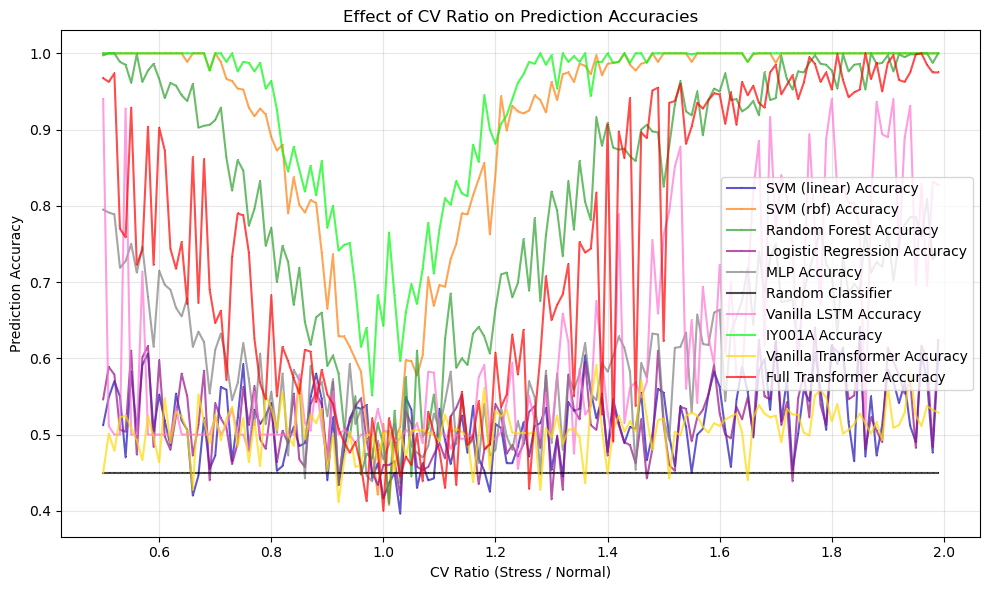

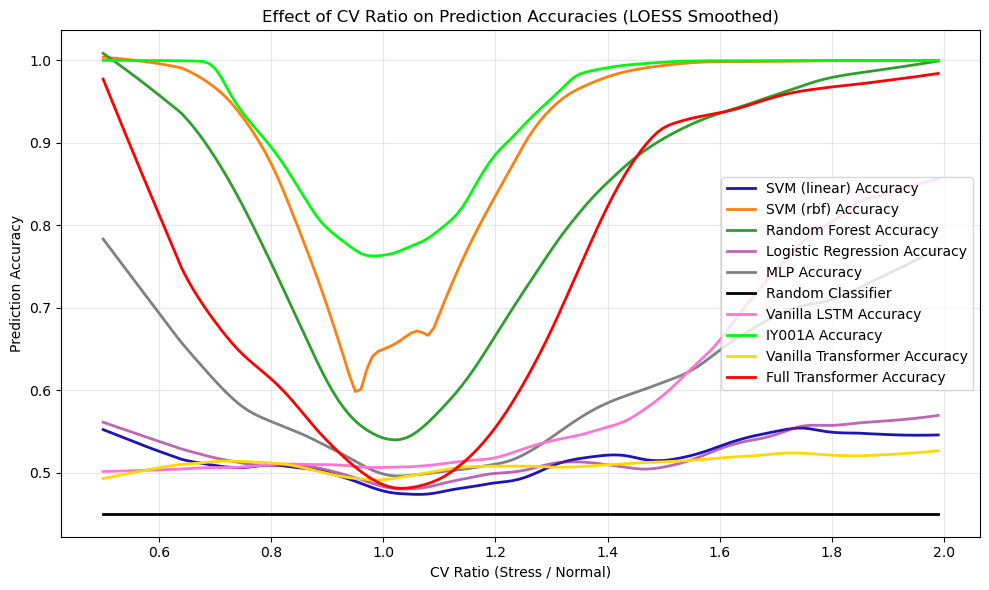

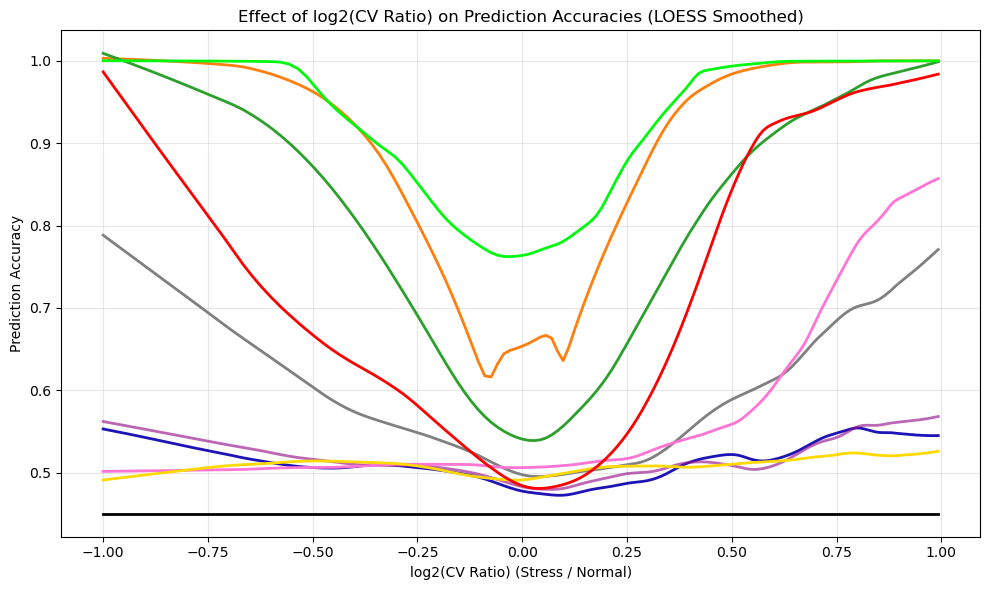

In [2]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
# Read in accuracy data, 
df_IY007 = pd.read_csv("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/IY007A.csv")

cv_ratios_recorded = df_IY007["CV Ratio"].unique()
#then compute mean and loess
linear_svm_accuracy = df_IY007.groupby("CV Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_IY007.groupby("CV Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_IY007.groupby("CV Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_IY007.groupby("CV Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_IY007.groupby("CV Ratio")["MLP Accuracy"].mean()
random_accuracy = df_IY007.groupby("CV Ratio")["Random Classifier Accuracy"].mean()
lstm_accuracy = df_IY007.groupby("CV Ratio")["Vanilla LSTM Accuracy"].mean()
iy001a_accuracy = df_IY007.groupby("CV Ratio")["IY001A Accuracy"].mean()
vanilla_transformer_accuracy = df_IY007.groupby("CV Ratio")["Vanilla Transformer Accuracy"].mean()
full_transformer_accuracy = df_IY007.groupby("CV Ratio")["Full Transformer Accuracy"].mean()

# Define a better color palette for improved visibility
colors = {
    'linear_svm': "#1E13B6",      
    'rbf_svm': '#ff7f0e',          # Orange
    'random_forest': '#2ca02c',    # Green
    'logistic_reg': "#96118ba3",    # Pink
    'mlp': 'gray',              #   Gray
    'random': 'Black',           # Black
    'lstm': "#ff74d5",             # Pink
    'iy001a': "#02f80f",           # Yellow-green
    'iy002a': '#17becf',           # Cyan
    'vanilla_transformer': "#ffd901", # Yellow
    'full_transformer': "#ff0000"  # Red
}

# Plot the raw data with improved colors
plt.figure(figsize=(10, 6))
# Plot CV Ratio vs Classifier Accuracies
plt.plot(cv_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color=colors['linear_svm'], label="SVM (linear) Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color=colors['rbf_svm'], label="SVM (rbf) Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color=colors['random_forest'], label="Random Forest Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color=colors['logistic_reg'], label="Logistic Regression Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color=colors['mlp'], label="MLP Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, random_accuracy, marker=',', linestyle='-', color=colors['random'], label="Random Classifier", alpha=0.7)
plt.plot(cv_ratios_recorded, lstm_accuracy, marker=',', linestyle='-', color=colors['lstm'], label="Vanilla LSTM Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, iy001a_accuracy, marker=',', linestyle='-', color=colors['iy001a'], label="IY001A Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, vanilla_transformer_accuracy, marker=',', linestyle='-', color=colors['vanilla_transformer'], label="Vanilla Transformer Accuracy", alpha=0.7)
plt.plot(cv_ratios_recorded, full_transformer_accuracy, marker=',', linestyle='-', color=colors['full_transformer'], label="Full Transformer Accuracy", alpha=0.7)

plt.xlabel("CV Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of CV Ratio on Prediction Accuracies")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
# plt.savefig("figs/variance_ratio_vs_accuracy_better_colors.png", bbox_inches='tight')
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, cv_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, cv_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, cv_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, cv_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, cv_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, cv_ratios_recorded, frac=0.2)
lstm_loess = lowess(lstm_accuracy, cv_ratios_recorded, frac=0.2)
iy001a_loess = lowess(iy001a_accuracy, cv_ratios_recorded, frac=0.2)
vanilla_transformer_loess = lowess(vanilla_transformer_accuracy, cv_ratios_recorded, frac=0.2)
full_transformer_loess = lowess(full_transformer_accuracy, cv_ratios_recorded, frac=0.2)
# Plot the LOESS smoothed data with improved colors
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color=colors['linear_svm'], linewidth=2, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color=colors['rbf_svm'], linewidth=2, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color=colors['random_forest'], linewidth=2, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color=colors['logistic_reg'], linewidth=2, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color=colors['mlp'], linewidth=2, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color=colors['random'], linewidth=2, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color=colors['lstm'], linewidth=2, label="Vanilla LSTM Accuracy")
plt.plot(iy001a_loess[:, 0], iy001a_loess[:, 1], linestyle='-', color=colors['iy001a'], linewidth=2, label="IY001A Accuracy")
# Uncomment if you have iy002a_loess
# plt.plot(iy002a_loess[:, 0], iy002a_loess[:, 1], linestyle='-', color=colors['iy002a'], linewidth=2, label="IY002A Accuracy")
plt.plot(vanilla_transformer_loess[:, 0], vanilla_transformer_loess[:, 1], linestyle='-', color=colors['vanilla_transformer'], linewidth=2, label="Vanilla Transformer Accuracy")
plt.plot(full_transformer_loess[:, 0], full_transformer_loess[:, 1], linestyle='-', color=colors['full_transformer'], linewidth=2, label="Full Transformer Accuracy")

plt.xlabel("CV Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of CV Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
# plt.savefig("figs/variance_ratio_vs_accuracy_loess_better_colors.png", bbox_inches='tight')
plt.show()

# Compute log2 of CV ratios
log2_cv_ratios = np.log2(cv_ratios_recorded)
# re-compute the loess smoothed data with log2 CV ratios
linear_svm_loess = lowess(linear_svm_accuracy, log2_cv_ratios, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, log2_cv_ratios, frac=0.2)
rf_loess = lowess(rf_accuracy, log2_cv_ratios, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, log2_cv_ratios, frac=0.2)
mlp_loess = lowess(mlp_accuracy, log2_cv_ratios, frac=0.2)
random_loess = lowess(random_accuracy, log2_cv_ratios, frac=0.2)
lstm_loess = lowess(lstm_accuracy, log2_cv_ratios, frac=0.2)
iy001a_loess = lowess(iy001a_accuracy, log2_cv_ratios, frac=0.2)
vanilla_transformer_loess = lowess(vanilla_transformer_accuracy, log2_cv_ratios, frac=0.2)
full_transformer_loess = lowess(full_transformer_accuracy, log2_cv_ratios, frac=0.2)

# plot the x-asis as log2(cv ratio) - lowess smoothed
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color=colors['linear_svm'], linewidth=2, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color=colors['rbf_svm'], linewidth=2, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color=colors['random_forest'], linewidth=2, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color=colors['logistic_reg'], linewidth=2, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color=colors['mlp'], linewidth=2, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color=colors['random'], linewidth=2, label="Random Classifier")
plt.plot(lstm_loess[:, 0], lstm_loess[:, 1], linestyle='-', color=colors['lstm'], linewidth=2, label="Vanilla LSTM Accuracy")
plt.plot(iy001a_loess[:, 0], iy001a_loess[:, 1], linestyle='-', color=colors['iy001a'], linewidth=2, label="IY001A Accuracy")
plt.plot(vanilla_transformer_loess[:, 0], vanilla_transformer_loess[:, 1], linestyle='-', color=colors['vanilla_transformer'], linewidth=2, label="Vanilla Transformer Accuracy")
plt.plot(full_transformer_loess[:, 0], full_transformer_loess[:, 1], linestyle='-', color=colors['full_transformer'], linewidth=2, label="Full Transformer Accuracy")
plt.xlabel("log2(CV Ratio) (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of log2(CV Ratio) on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True, alpha=0.3)
# plt.legend()
plt.tight_layout()
# plt.savefig("figs/cv_ratio_vs_accuracy_loess_log2_better_colors.png", bbox_inches='tight')
plt.show()

## Comparing specified CV vs observed CV in synthetic data

In IY007.py, we generate synthetic data with specific CV (Coefficient of Variation) targets. The CV is specified as a ratio between stress and normal conditions. This script will:

1. Load the synthetic data generated by IY007.py
2. Calculate the observed CV from the actual data
3. Compare the observed CV to the CV that was specified in the parameters
4. Plot the specified CV against the observed CV to check how well they match

In [4]:
# Load the CV data
cv_df = load_cv_data()

if cv_df is not None and not cv_df.empty:
    print(f"Loaded data for {len(cv_df)} simulations")
    
    # Group by specified CV ratio to calculate mean and std of observed values
    grouped_df = cv_df.groupby('specified_cv_ratio').agg({
        'observed_cv_ratio': ['mean', 'std'],
        'observed_cv_stress': ['mean', 'std'],
        'observed_cv_normal': ['mean', 'std']
    }).reset_index()
    
    # Flatten the multi-level columns
    grouped_df.columns = ['_'.join(col).strip('_') for col in grouped_df.columns.values]
    
    print(f"Data grouped into {len(grouped_df)} unique CV ratios")
    
    # Sort by specified CV ratio
    grouped_df = grouped_df.sort_values('specified_cv_ratio')
else:
    print("No data available for analysis")

Found 49 CV trajectory directories


Processing CV directories:   0%|          | 0/49 [00:00<?, ?it/s]

Processing CV directories: 100%|██████████| 49/49 [00:02<00:00, 18.48it/s]

Loaded data for 490 simulations
Data grouped into 49 unique CV ratios


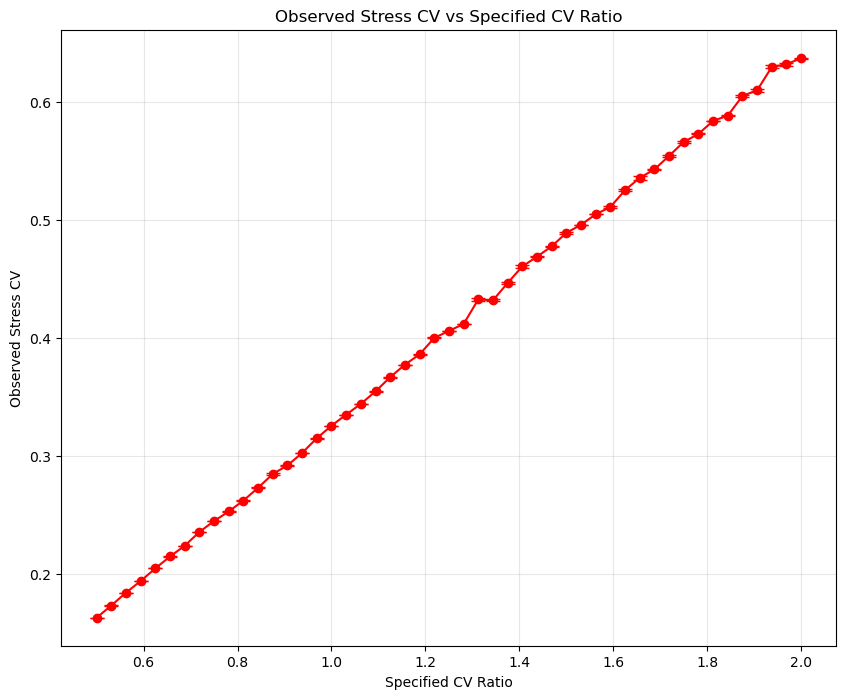

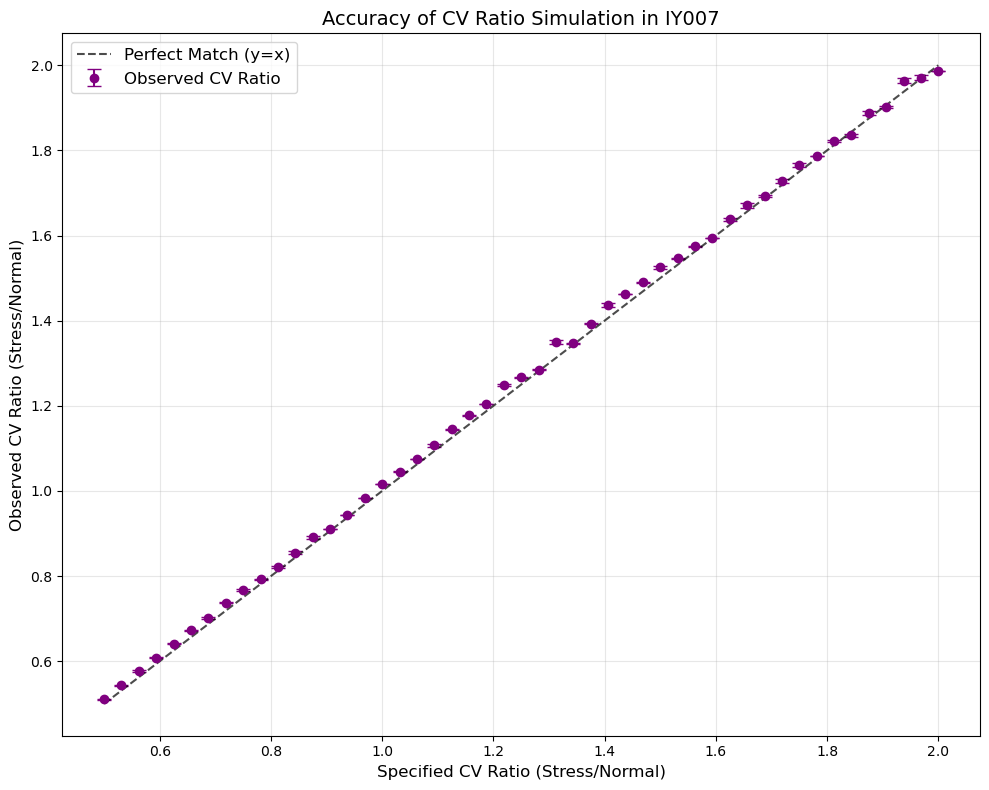

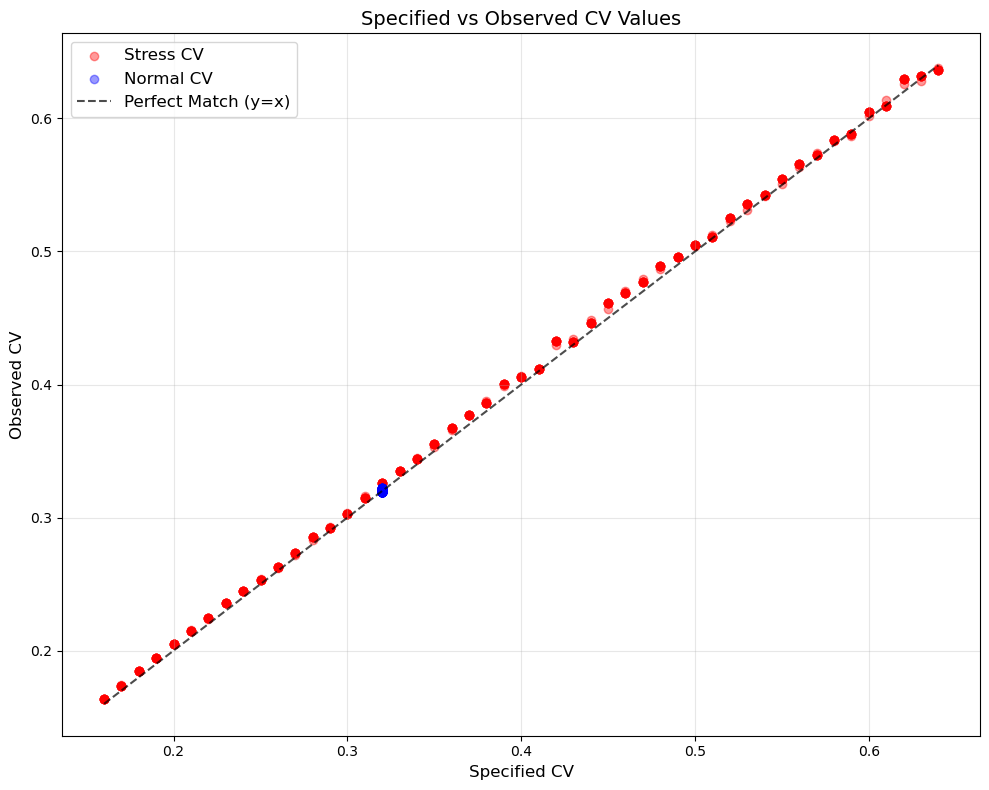

In [5]:
if 'grouped_df' in locals() and not grouped_df.empty:
    # Create plots
    # fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Specified CV Ratio vs Observed CV Ratio
    # axes[0].errorbar(
    #     grouped_df['specified_cv_ratio'], 
    #     grouped_df['observed_cv_ratio_mean'], 
    #     yerr=grouped_df['observed_cv_ratio_std'],
    #     fmt='o-', capsize=5
    # )
    
    # Add diagonal line (y=x) for reference
    min_val = min(grouped_df['specified_cv_ratio'].min(), grouped_df['observed_cv_ratio_mean'].min())
    max_val = max(grouped_df['specified_cv_ratio'].max(), grouped_df['observed_cv_ratio_mean'].max())
    # axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    # axes[0].set_xlabel('Specified CV Ratio (Stress/Normal)')
    # axes[0].set_ylabel('Observed CV Ratio (Stress/Normal)')
    # axes[0].set_title('Specified vs Observed CV Ratio')
    # axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Specified CV Stress vs Observed CV Stress
    plt.figure(figsize=(10, 8))
    plt.errorbar(
        grouped_df['specified_cv_ratio'], 
        grouped_df['observed_cv_stress_mean'], 
        yerr=grouped_df['observed_cv_stress_std'],
        fmt='o-', color='red', capsize=5, label='Stress CV'
    )
    plt.xlabel('Specified CV Ratio')
    plt.ylabel('Observed Stress CV')
    plt.title('Observed Stress CV vs Specified CV Ratio')
    plt.grid(True, alpha=0.3)

    # # Plot 3: Specified CV Normal vs Observed CV Normal
    # axes[2].errorbar(
    #     grouped_df['specified_cv_ratio'], 
    #     grouped_df['observed_cv_normal_mean'], 
    #     yerr=grouped_df['observed_cv_normal_std'],
    #     fmt='o-', color='blue', capsize=5
    # )
    # axes[2].set_xlabel('Specified CV Ratio')
    # axes[2].set_ylabel('Observed Normal CV')
    # axes[2].set_title('Observed Normal CV vs Specified CV Ratio')
    # axes[2].grid(True, alpha=0.3)
    
    # plt.tight_layout()
    # plt.savefig("cv_comparison_plots.png", dpi=300)
    # plt.show()
    
    # Create a single plot comparing specified vs observed CV ratios with diagonal line
    plt.figure(figsize=(10, 8))
    plt.errorbar(
        grouped_df['specified_cv_ratio'], 
        grouped_df['observed_cv_ratio_mean'], 
        yerr=grouped_df['observed_cv_ratio_std'],
        fmt='o', color='purple', capsize=5, label='Observed CV Ratio'
    )
    
    # Add diagonal line (y=x) for reference
    min_val = min(grouped_df['specified_cv_ratio'].min(), grouped_df['observed_cv_ratio_mean'].min())
    max_val = max(grouped_df['specified_cv_ratio'].max(), grouped_df['observed_cv_ratio_mean'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='Perfect Match (y=x)')
    
    plt.xlabel('Specified CV Ratio (Stress/Normal)', fontsize=12)
    plt.ylabel('Observed CV Ratio (Stress/Normal)', fontsize=12)
    plt.title('Accuracy of CV Ratio Simulation in IY007', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("cv_ratio_comparison.png", dpi=300)
    plt.show()
    
    # Combined plot to see all data together
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot of all data points
    plt.scatter(
        cv_df['specified_cv_stress'], 
        cv_df['observed_cv_stress'],
        color='red', alpha=0.4, label='Stress CV'
    )
    
    plt.scatter(
        cv_df['specified_cv_normal'], 
        cv_df['observed_cv_normal'],
        color='blue', alpha=0.4, label='Normal CV'
    )
    
    # Add diagonal line (y=x) for reference
    min_val = min(cv_df['specified_cv_stress'].min(), cv_df['specified_cv_normal'].min(), 
                 cv_df['observed_cv_stress'].min(), cv_df['observed_cv_normal'].min())
    max_val = max(cv_df['specified_cv_stress'].max(), cv_df['specified_cv_normal'].max(),
                 cv_df['observed_cv_stress'].max(), cv_df['observed_cv_normal'].max())
    
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='Perfect Match (y=x)')
    
    plt.xlabel('Specified CV', fontsize=12)
    plt.ylabel('Observed CV', fontsize=12)
    plt.title('Specified vs Observed CV Values', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("combined_specified_vs_observed_cv.png", dpi=300)
    plt.show()


Summary Statistics for CV Ratio Simulation Accuracy:
Mean Absolute Error: 0.0144
Mean Percentage Error: 1.34%
Median Absolute Error: 0.0145
Median Percentage Error: 1.36%


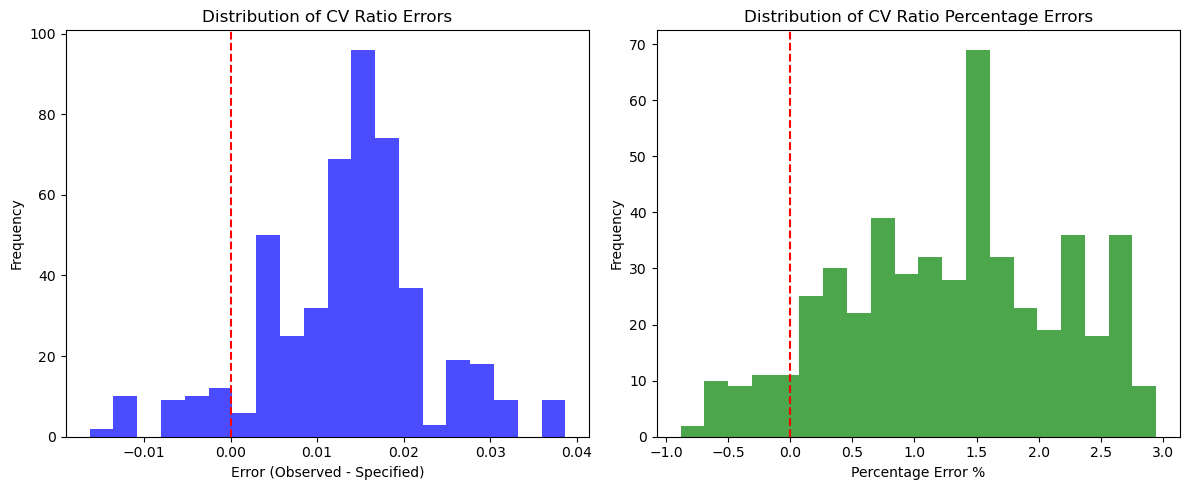

In [ ]:
if 'cv_df' in locals() and not cv_df.empty:
    # Calculate error metrics
    cv_df['ratio_error'] = cv_df['observed_cv_ratio'] - cv_df['specified_cv_ratio']
    cv_df['ratio_pct_error'] = (cv_df['ratio_error'] / cv_df['specified_cv_ratio']) * 100
    
    # Calculate summary statistics
    mean_abs_error = np.abs(cv_df['ratio_error']).mean()
    mean_pct_error = np.abs(cv_df['ratio_pct_error']).mean()
    median_abs_error = np.median(np.abs(cv_df['ratio_error']))
    median_pct_error = np.median(np.abs(cv_df['ratio_pct_error']))
    
    print("\nSummary Statistics for CV Ratio Simulation Accuracy:")
    print(f"Mean Absolute Error: {mean_abs_error:.4f}")
    print(f"Mean Percentage Error: {mean_pct_error:.2f}%")
    print(f"Median Absolute Error: {median_abs_error:.4f}")
    print(f"Median Percentage Error: {median_pct_error:.2f}%")
    
    # Show the distribution of errors
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(cv_df['ratio_error'], bins=20, alpha=0.7, color='blue')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Error (Observed - Specified)')
    plt.ylabel('Frequency')
    plt.title('Distribution of CV Ratio Errors')
    
    plt.subplot(1, 2, 2)
    plt.hist(cv_df['ratio_pct_error'], bins=20, alpha=0.7, color='green')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Percentage Error %')
    plt.ylabel('Frequency')
    plt.title('Distribution of CV Ratio Percentage Errors')
    
    plt.tight_layout()
    plt.savefig("cv_error_distributions.png", dpi=300)
    plt.show()

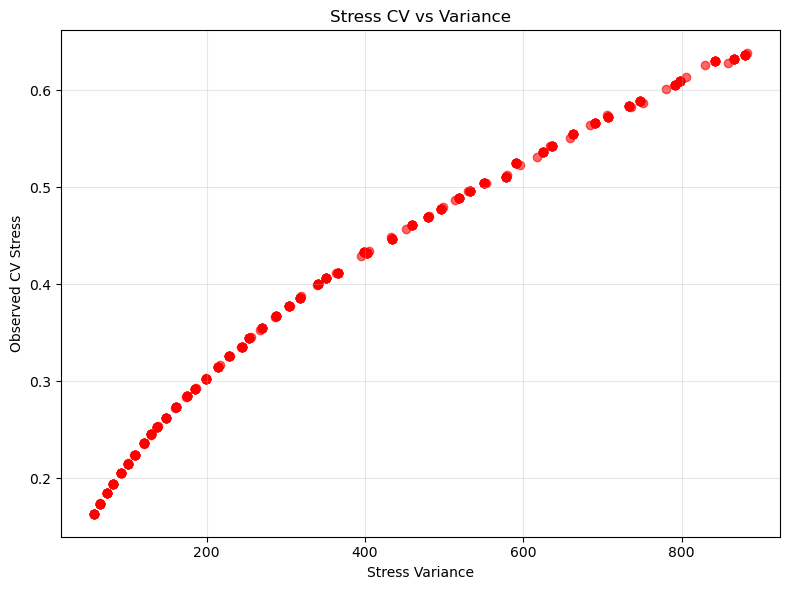

In [14]:
if 'cv_df' in locals() and not cv_df.empty:
    plt.figure(figsize=(8, 6))
    plt.scatter(cv_df['stress_variance'], cv_df['observed_cv_stress'], alpha=0.6, color='red')
    plt.xlabel('Stress Variance')
    plt.ylabel('Observed CV Stress')
    plt.title('Stress CV vs Variance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("cv_stress_vs_variance.png", dpi=300)
    plt.show()


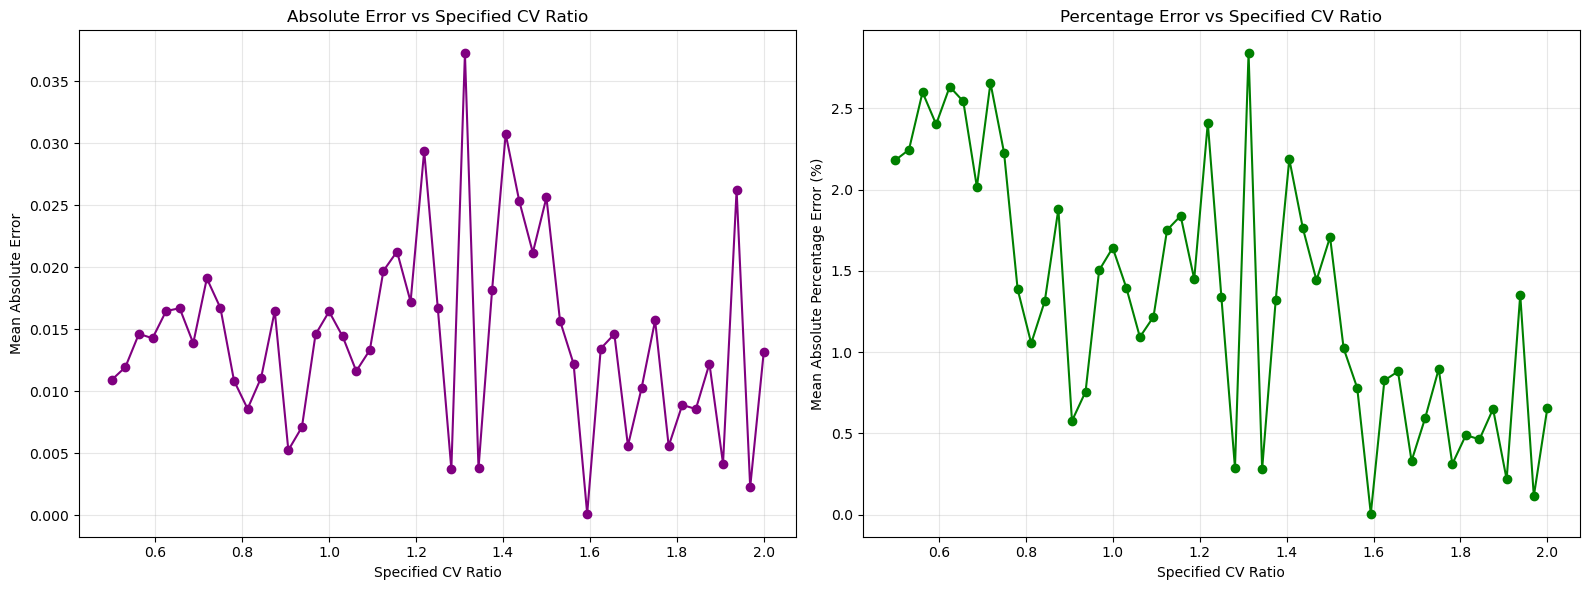

In [ ]:
if 'grouped_df' in locals() and not grouped_df.empty:
    # Calculate ratio error and percentage error
    grouped_df['ratio_error_mean'] = grouped_df['observed_cv_ratio_mean'] - grouped_df['specified_cv_ratio']
    grouped_df['ratio_pct_error_mean'] = (grouped_df['ratio_error_mean'] / grouped_df['specified_cv_ratio']) * 100
    
    # Plot error trends
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Absolute Error vs Specified CV Ratio
    axes[0].plot(grouped_df['specified_cv_ratio'], np.abs(grouped_df['ratio_error_mean']), 'o-', color='purple')
    axes[0].set_xlabel('Specified CV Ratio')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_title('Absolute Error vs Specified CV Ratio')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Percentage Error vs Specified CV Ratio
    axes[1].plot(grouped_df['specified_cv_ratio'], np.abs(grouped_df['ratio_pct_error_mean']), 'o-', color='green')
    axes[1].set_xlabel('Specified CV Ratio')
    axes[1].set_ylabel('Mean Absolute Percentage Error (%)')
    axes[1].set_title('Percentage Error vs Specified CV Ratio')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("cv_error_trends.png", dpi=300)
    plt.show()

## Conclusion

This analysis provides insights into how well the CV values specified in the simulation parameters match the actual CV values observed in the generated data. The key findings include:

1. How closely the observed CV ratios match the specified CV ratios
2. Whether there are systematic biases or errors in the CV simulation
3. How the accuracy varies across different CV ratio values
4. The relationships between CV, mean, and variance in the simulated data

These insights can help validate the simulation approach in IY007.py and identify any potential issues that need to be addressed in the model or parameter selection.